<Axes: xlabel='Date'>

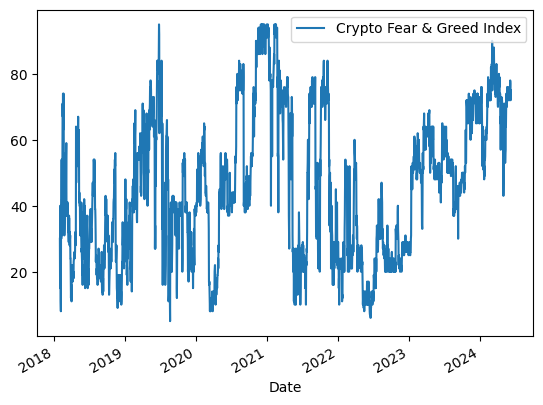

In [3]:
import requests

url = "https://alternative.me/api/crypto/fear-and-greed-index/history"
payload = {
    "days": 100000
}

response = requests.post(url, json=payload)

import pandas as pd
dates = response.json()['data']['labels']
values = response.json()['data']['datasets'][0]['data']

# Creating DataFrame
fear_and_greed = pd.DataFrame({
    'Date': dates,
    'Crypto Fear & Greed Index': values
})

fear_and_greed['Date'] = pd.to_datetime(fear_and_greed.Date)

fear_and_greed.set_index('Date').plot()


In [4]:


import requests
def fetch_ethereum_daily_prices(api_key):
    url = "https://min-api.cryptocompare.com/data/v2/histoday"
    parameters = {
        'fsym': 'ETH',  # From Symbol: Ethereum
        'tsym': 'USD',  # To Symbol: USD
        'limit': 2000,    # Number of data points (days)
        'api_key': api_key
    }
    response = requests.get(url, params=parameters)
    data = response.json()
    if data['Response'] == 'Success':
        return data['Data']['Data']
    else:
        return "An error occurred: " + data['Message']


api_key = '038ebb6388bd47ca996f19135a24ec40b612f901821e34ab030d08b0f919f49e'
eth_prices_req = fetch_ethereum_daily_prices(api_key)

In [18]:
from datetime import datetime

eth_prices = pd.DataFrame(eth_prices_req)

dates = [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d') for ts in eth_prices.time]
eth_prices["dates"] = dates
eth_prices["Ethereum_Price"] = eth_prices.close
eth_prices["dates"] = pd.to_datetime(eth_prices.dates)

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

eth_prices['Date'] = pd.to_datetime(eth_prices['dates'])
eth_prices = eth_prices[['Date', 'Ethereum_Price']]
merged_df = pd.merge(eth_prices, fear_and_greed, on='Date')
merged_df['Price_Change'] = merged_df['Ethereum_Price'].pct_change().shift(-1)

# Create the target variable
def classify_movement(change):
    if pd.isna(change):
        return 'flat'
    elif change > 0.01:
        return 'up'
    elif change < -0.01:
        return 'down'
    else:
        return 'flat'

merged_df['Price_Movement'] = merged_df['Price_Change'].shift(-1).apply(classify_movement)

# Drop rows with NaN values which occur due to the shift operation
merged_df.dropna(inplace=True)

# Prepare features and labels
X = merged_df[['Crypto Fear & Greed Index']]
y = merged_df['Price_Movement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
merged_df

,Date,Ethereum_Price,Crypto Fear & Greed Index,Price_Change,Price_Movement
0,2018-12-18,101.93,23,-0.012754,up
1,2018-12-19,100.63,21,0.157011,down
2,2018-12-20,116.43,27,-0.060380,up
3,2018-12-21,109.40,35,0.076051,up
4,2018-12-22,117.72,28,0.116633,up
...,...,...,...,...,...
1995,2024-06-04,3810.73,73,0.014624,down
1996,2024-06-05,3866.46,75,-0.014072,down
1997,2024-06-06,3812.05,78,-0.035482,flat
1998,2024-06-07,3676.79,77,0.001102,flat


<Axes: xlabel='Date'>

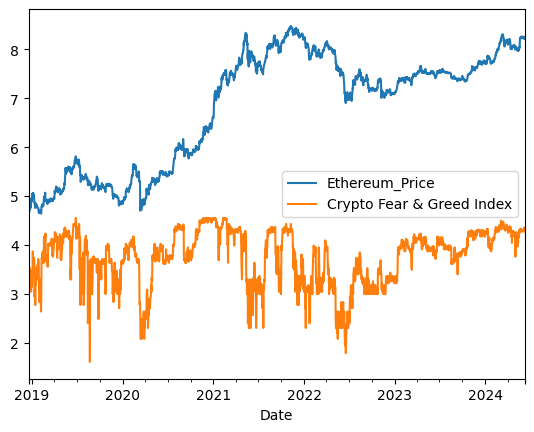

In [20]:
import numpy as np

np.log(merged_df.set_index('Date')[['Ethereum_Price', 'Crypto Fear & Greed Index']]).plot()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 1
[LightGBM] [Info] Start training from score -1.069660
[LightGBM] [Info] Start training from score -1.261867
[LightGBM] [Info] Start training from score -0.984168
              precision    recall  f1-score   support

        down       0.34      0.38      0.36       131
        flat       0.39      0.32      0.35       113
          up       0.40      0.41      0.40       156

    accuracy                           0.38       400
   macro avg       0.38      0.37      0.37       400
weighted avg       0.38      0.38      0.37       400

False    0.625
True     0.375
Name: Price_Movement, dtype: float64


<Axes: ylabel='Price_Movement'>

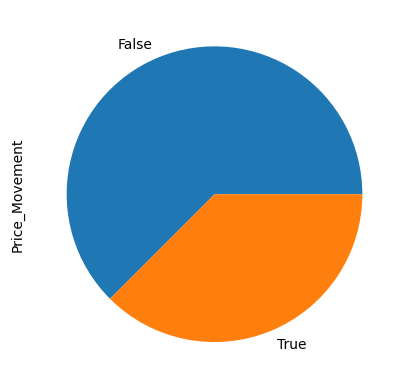

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import classification_report


# Create the target variable
def classify_movement(change):
    if pd.isna(change):
        return 'flat'
    elif change > 0.01:
        return 'up'
    elif change < -0.01:
        return 'down'
    else:
        return 'flat'


# Convert labels to numeric values for LightGBM
label_mapping = {'up': 2, 'flat': 1, 'down': 0}
y = y.map(label_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize three LightGBM models
model1 = lgb.LGBMClassifier()

# Train the models
model1.fit(X_train, y_train)


# Predict probabilities
probs1 = model1.predict_proba(X_test)


# Determine the highest predicted category
y_pred = probs1.argmax(axis=1)

# Convert numeric predictions back to labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_pred_labels = pd.Series(y_pred).map(inverse_label_mapping)
y_test_labels = y_test.map(inverse_label_mapping)

# Evaluate the model
print(classification_report(y_test_labels, y_pred_labels))
print(pd.Series((y_test ==y_pred)).value_counts(normalize=True))
pd.Series((y_test ==y_pred)).value_counts(normalize=True).plot(kind='pie')

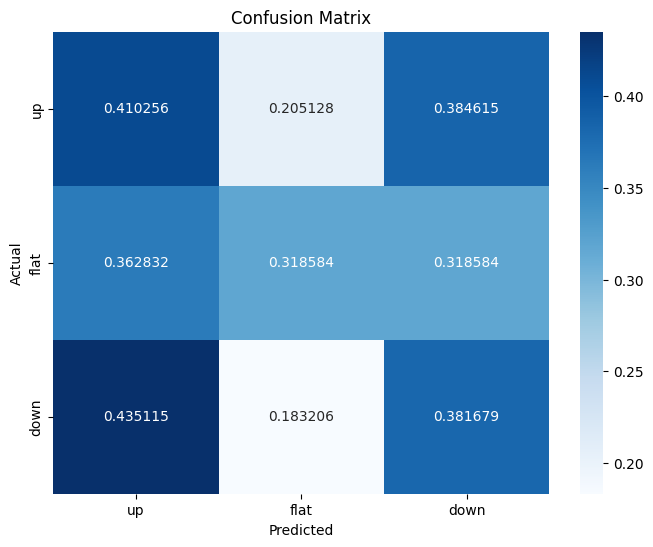

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=['up', 'flat', 'down'], normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=['up', 'flat', 'down'], yticklabels=['up', 'flat', 'down'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


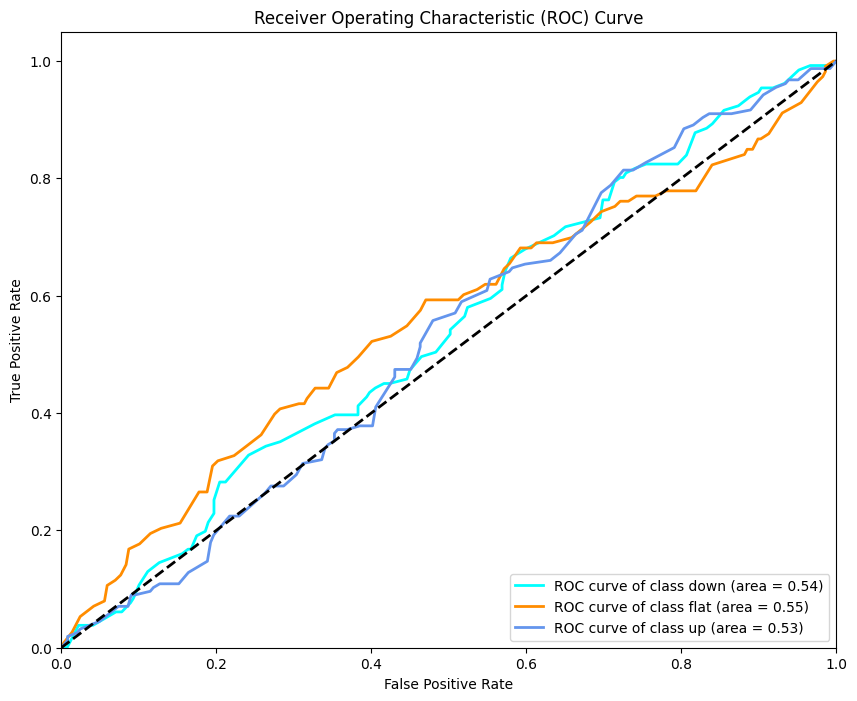

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels for multiclass ROC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probs1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(inverse_label_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


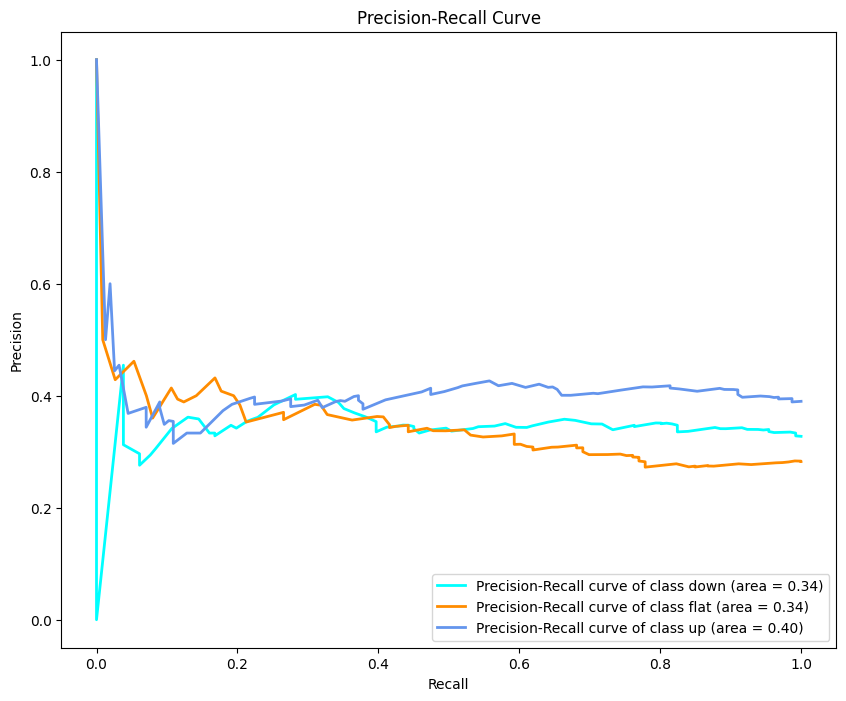

In [28]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve and PR area for each class
precision = dict()
recall = dict()
pr_auc = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], probs1[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot all Precision-Recall curves
plt.figure(figsize=(10, 8))
for i, color in enumerate(colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'
             ''.format(inverse_label_mapping[i], pr_auc[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()


In [41]:
from giza.zkcook import mcr

model_cmr, transformer = mcr(model = model1,
                         X_train = X_train,
                         y_train = y_train, 
                         X_eval = X_test, 
                         y_eval = y_test, 
                         eval_metric = 'multi_error')
                        
                        
y_pred = model_cmr.predict(X_test)

Adjusting num_leaves to new range: [20, 31]


In [ ]:
from giza.zkcook import serialize_model

serialize_model(model_cmr, "./MCR model.json")